# Machine Learing Project to predict Digital Ad Fraud Nov-16-2018

In [1]:
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization, Activation
from keras.utils import normalize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1. Import the dataset

In [2]:
#dataset = pd.read_csv("/Users/cmallavarapu/Documents/Chiran/MSDS/ML/MLProject/train_sample.csv")
dataset = pd.read_csv("/Users/bujji/Documents/MS_SMU/Sem_5_ML/MLProject/train_sample.csv")
#dataset = pd.read_csv("/Users/chiranjeevimallavarapu/Documents/Chiran/MS_SMU/ML/MLProject/train_sample.csv")



In [3]:
dataset.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


### 1.1 Field definitions

####                    ip:  
                ip address of click.

####                   app: 
                app id for marketing.

####                device: 
                device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)

####                    os: 
                os version id of user mobile phone

####               channel: 
                channel id of mobile ad publisher

####            click_time: 
                timestamp of click (UTC)

####       attributed_time: 
                if user download the app for after clicking an ad, this is the time of the app download

####         is_attributed: 
                the target that is to be predicted, indicating the app was downloaded

In [4]:
len(dataset)

100000

### 1.2 Adjust 'click_time' date value to pandas date and calculate time delta from min time

In [5]:
dataset['click_time'] = pd.to_datetime(dataset['click_time'])

In [6]:
sttime = pd.Timestamp(min(dataset['click_time']))

In [7]:
sttime

Timestamp('2017-11-06 16:00:00')

In [8]:
dataset['delta'] = (dataset['click_time']-sttime).astype('timedelta64[s]')

In [9]:
dataset.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,delta
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,63038.0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,78027.0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,93924.0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,46688.0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,234009.0


##  2. Explore the data

In [10]:
import seaborn as sns
sns.set(style="ticks")

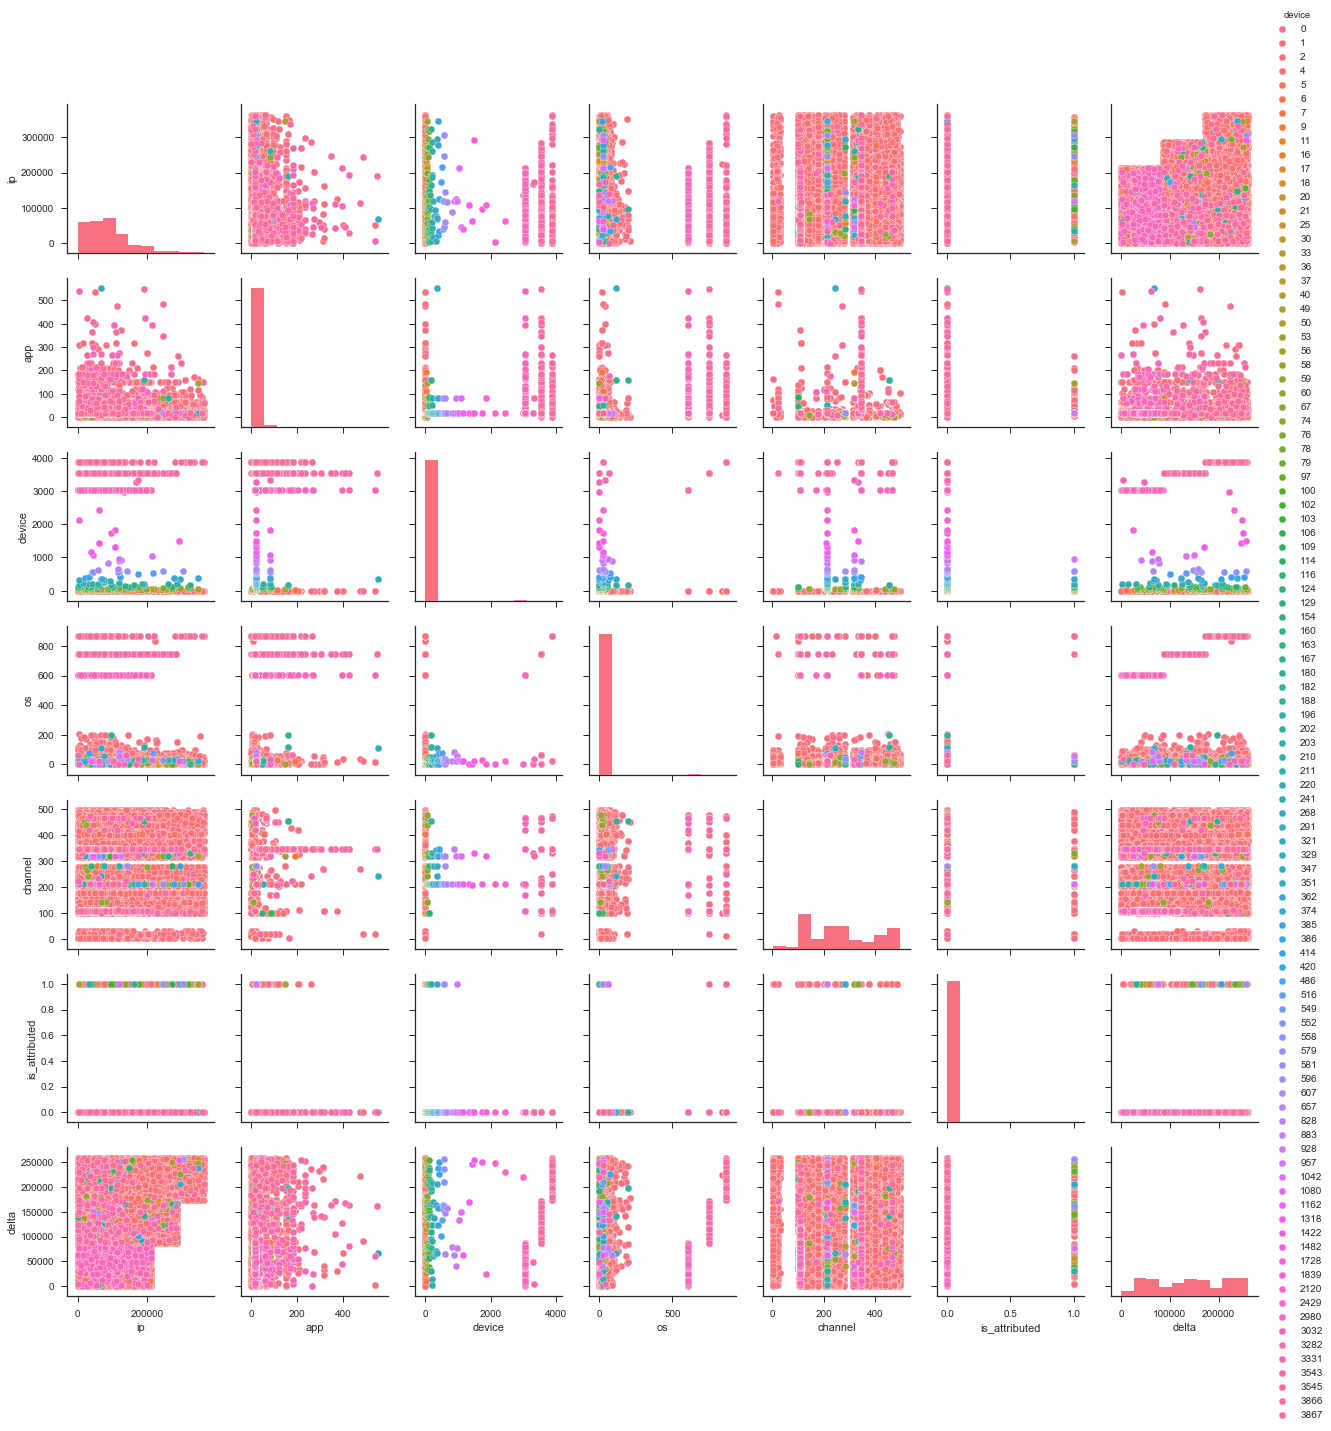

In [11]:
sns.pairplot(dataset, hue="device")

### 2.1 Lets plot Is_Attributed Vs app

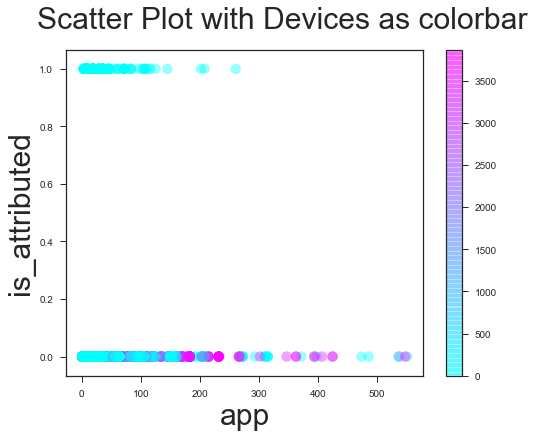

In [12]:
np.random.seed(19680801)
fig = plt.figure(figsize=(8,6))

N = 50
#colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

colors = dataset['device']

# c=colors,
scatter=plt.scatter(dataset['app'], dataset['is_attributed'], s=100,alpha=0.4, c = colors,cmap='cool')
fig.suptitle('Scatter Plot with Devices as colorbar', fontsize=30)
plt.xlabel('app', fontsize=30)
plt.ylabel('is_attributed', fontsize=30)


plt.colorbar(scatter)
plt.show()

### 2.2 Lets plot Is_Attributed vs Device

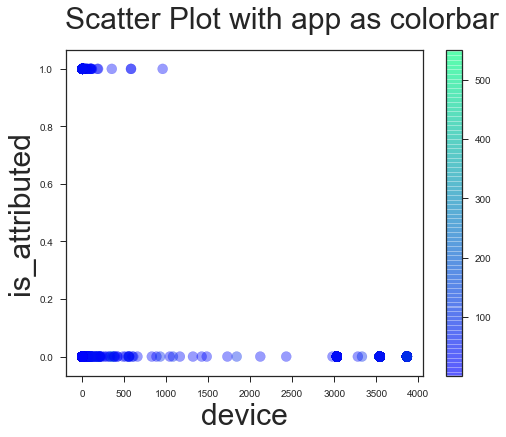

In [13]:
np.random.seed(19680801)
fig = plt.figure(figsize=(8,6))

N = 50
#colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

colors = dataset['app']

# c=colors,
scatter=plt.scatter(dataset['device'], dataset['is_attributed'], s=100,alpha=0.40, c = colors,cmap='winter')
fig.suptitle('Scatter Plot with app as colorbar', fontsize=30)
plt.xlabel('device', fontsize=30)
plt.ylabel('is_attributed', fontsize=30)


plt.colorbar(scatter)
plt.show()

### 2.3 Lets plot Is_Attributed vs OS

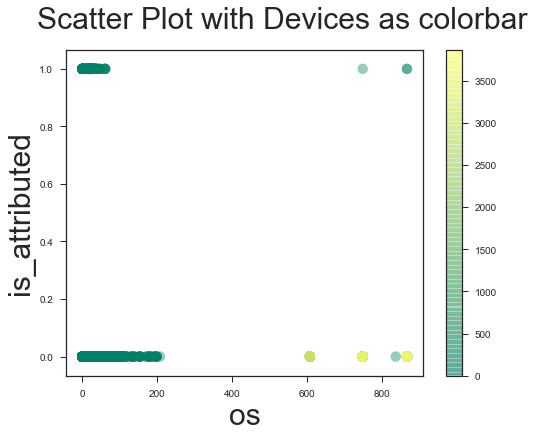

In [14]:
np.random.seed(19680801)
fig = plt.figure(figsize=(8,6))

N = 50
#colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

colors = dataset['device']

# c=colors,
scatter=plt.scatter(dataset['os'], dataset['is_attributed'], s=100,alpha=0.4, c = colors,cmap='summer')
fig.suptitle('Scatter Plot with Devices as colorbar', fontsize=30)
plt.xlabel('os', fontsize=30)
plt.ylabel('is_attributed', fontsize=30)


plt.colorbar(scatter)
plt.show()

##  3. Lets model the data using Deep Neural Networks

In [15]:
# Slice the dataset to get the features (X) and Response(Y)

In [16]:
X_imb = np.array(dataset)[:,[0,1,2,3,4,8]]
Y_imb = np.array(dataset)[:,7]

### 3.1 Balancing the dataset

We know that the nature of this data (Fraud Detection) is such that very little percentage of response variable can be considered attributed (someone installed an APP) and major portion of data is considered fraudulent. 

Hence we will technique of combining over and under sampling i.e Class to perform over-sampling using SMOTE and cleaning using ENN (Edited nearest neighbours). This will result in a more balanced class of response(app installed or not after clicking an ad)

In [17]:
from collections import Counter
from imblearn.combine import SMOTEENN
sme = SMOTEENN(random_state=42)
X, Y = sme.fit_resample(X_imb, Y_imb)

/anaconda3/lib/python3.6/site-packages/imblearn/utils/_validation.py:93: UserWarning: 'y' should be of types ('binary', 'multiclass', 'multilabel-indicator') only. Got unknown instead.
  TARGET_KIND, type_of_target(y)))
/anaconda3/lib/python3.6/site-packages/imblearn/utils/_validation.py:93: UserWarning: 'y' should be of types ('binary', 'multiclass', 'multilabel-indicator') only. Got unknown instead.
  TARGET_KIND, type_of_target(y)))
/anaconda3/lib/python3.6/site-packages/imblearn/utils/_validation.py:93: UserWarning: 'y' should be of types ('binary', 'multiclass', 'multilabel-indicator') only. Got unknown instead.
  TARGET_KIND, type_of_target(y)))
/anaconda3/lib/python3.6/site-packages/imblearn/utils/_validation.py:93: UserWarning: 'y' should be of types ('binary', 'multiclass', 'multilabel-indicator') only. Got unknown instead.
  TARGET_KIND, type_of_target(y)))


In [18]:
print ("Total rows of feature data before balancing is", len(X_imb), "with attributed rows",len(Y_imb[Y_imb==1]), "after SMOTEENN total rows of feature data is" ,len(X), "with attributed data",len(Y[Y==1]))

Total rows of feature data before balancing is 100000 with attributed rows 227 after SMOTEENN total rows of feature data is 175029 with attributed data 91448


### 3.2 Classification of response

Now lets convert our response variable to a class variable so we can feed to DNN

In [19]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

### 3.3 Model with simple feed forward DNN

In [21]:
model = Sequential()
model.add(Dense(12, input_dim=6, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(8, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, dummy_y, epochs=20, batch_size=1000)
scores = model.evaluate(X, dummy_y)
print("hi", "\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/20
175029/175029 [==============================] - 3s 19us/step - loss: 0.6106 - acc: 0.6437
Epoch 2/20
175029/175029 [==============================] - 2s 12us/step - loss: 0.5356 - acc: 0.7440
Epoch 3/20
175029/175029 [==============================] - 2s 12us/step - loss: 0.5191 - acc: 0.7524
Epoch 4/20
175029/175029 [==============================] - 2s 12us/step - loss: 0.5031 - acc: 0.7700
Epoch 5/20
175029/175029 [==============================] - 2s 13us/step - loss: 0.4848 - acc: 0.7771
Epoch 6/20
175029/175029 [==============================] - 2s 13us/step - loss: 0.4648 - acc: 0.7865
Epoch 7/20
175029/175029 [==============================] - 2s 13us/step - loss: 0.4531 - acc: 0.7886
Epoch 8/20
175029/175029 [==============================] - 2s 13us/step - loss: 0.4418 - acc: 0.7930
Epoch 9/20
175029/175029 [==============================] - 2s 13us/step - loss: 0.4325 - acc: 0.7954
Epoch 10/20
175029/175029 [==============================] - 2s 12us/step - loss: 

#### This resulted a good accuracy but we are not sure if it is overfitting as we did not cross validate

### 3.4 Model with CNN along with Cross Validation

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, dummy_y, test_size=0.2, random_state=42)

In [24]:
import string
import random
import numpy as np

from keras.utils import np_utils
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Embedding, SpatialDropout1D, Conv1D,Conv2D
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D

#### Now the CNN is architected per below

Convolutional Layer

Pooling Layer

Normalization Layer

Fully-Connected Layer

In [25]:
# Standard off the shelf 
def create_model(i_shape):
    #refactored to allow for num_labels
    model = Sequential()
    
    # CNN : 16 layers, 3 filters 
    model.add(Conv1D(16, 3, input_shape=i_shape,padding='same', use_bias='False'))
    # Notice the Batch normalization that is critical for the data
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(SpatialDropout1D(0.2))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D())

    #model.add(Dense(32, input_dim=6, activation='relu'))
    #model.add(SpatialDropout1D(0.2))
    #model.add(Dropout(0.25))
    
    # CNN: 64 layers, 3 filters 
    model.add(Conv1D(64, 3, padding='same',  use_bias='False'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D())
    #model.add(Flatten())
    
     # CNN: 16 layers, 3 filters 
    model.add(Conv1D(16, 3, padding='same',  use_bias='False'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.25))
    #model.add(MaxPooling1D())

    # Fully connected layer 
    model.add(Dense(25, use_bias='False'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.25))
    model.add(Flatten())
    
    model.add(Dense(2, activation='sigmoid'))
    
    loss = 'binary_crossentropy'
    model.compile(loss=loss, optimizer= 'adam', metrics=['accuracy'])
    model.summary()
    return model

In [26]:
X_train = X_train.reshape(-1, 6, 1)
X_test= X_test.reshape(-1, 6, 1)

In [27]:
X_train.shape

(140023, 6, 1)

In [28]:
X_test.shape

(35006, 6, 1)

#### Construct and fit the model

In [29]:
clf = create_model(X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 6, 16)             64        
_________________________________________________________________
batch_normalization_3 (Batch (None, 6, 16)             64        
_________________________________________________________________
activation_3 (Activation)    (None, 6, 16)             0         
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 6, 16)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 16)             0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 16)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 64)             3136      
__________

In [ ]:
clf.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=10000)

Train on 140023 samples, validate on 35006 samples
Epoch 1/100
140023/140023 [==============================] - 22s 159us/step - loss: 0.7559 - acc: 0.5446 - val_loss: 0.5767 - val_acc: 0.6970
Epoch 2/100
 10000/140023 [=>............................] - ETA: 15s - loss: 0.6837 - acc: 0.6015

In [236]:
X = X.reshape(-1, 6, 1)

In [237]:
X.shape

(175029, 6, 1)

In [238]:
scores = clf.evaluate(X, dummy_y)
print("hi", "\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

175029/175029 [==============================] - 7s 43us/step
hi 
acc: 74.07%


### 3.5 Predict on test

In [224]:
X_ALL = X_test.reshape(-1, 6, 1)

Y_predict = clf.predict_classes(X_ALL)

In [225]:
len(Y_predict)

35006

#### As Y predict will be class data we will convert to single value to plot. As there are only two classes (0/1) we will simply set the Y as the value of second class (one hot encoded value) 

So for example Y predicted 

    Class 0(not attributed)     Class 1(attributed)

                     0          1
                     1          0
                 
In the above scenarios, Y (is attributed) should be 1, 0 respectively which is also equal to class value of class 1(attributed

In [226]:
Y_plot =  Y_test[:,1]

In [227]:
Y_plot.shape

(35006,)

### 3.6 Plot Predicted vs Actual for test data to get a visual representation

#### We will jitter the data a bit

In [228]:
for i in range(0,len(Y_plot)):
    #print()
    Y_plot[i] = Y_plot[i] + random.uniform(0, 0.25)
    if i%10000 ==0:
        print (Y_plot[i])

0.03370752
0.060792092
0.13455579
1.0489397


In [229]:
Y_plot.shape

(35006,)

In [230]:
Y_predict.shape

(35006,)

In [136]:
Y_predict = Y_predict.reshape(-1)

In [232]:
Y_predict = Y_predict.astype(np.float64)

In [233]:
for i in range(0,len(Y_predict)):
    #print()
    Y_predict[i] = Y_predict[i] + random.uniform(0, 0.25)
    if i %10000 == 0:
        print (Y_predict[i])
        
    

0.045972236169128794
1.1291402828621842
0.03226306251387229
1.002382114833591


No handles with labels found to put in legend.


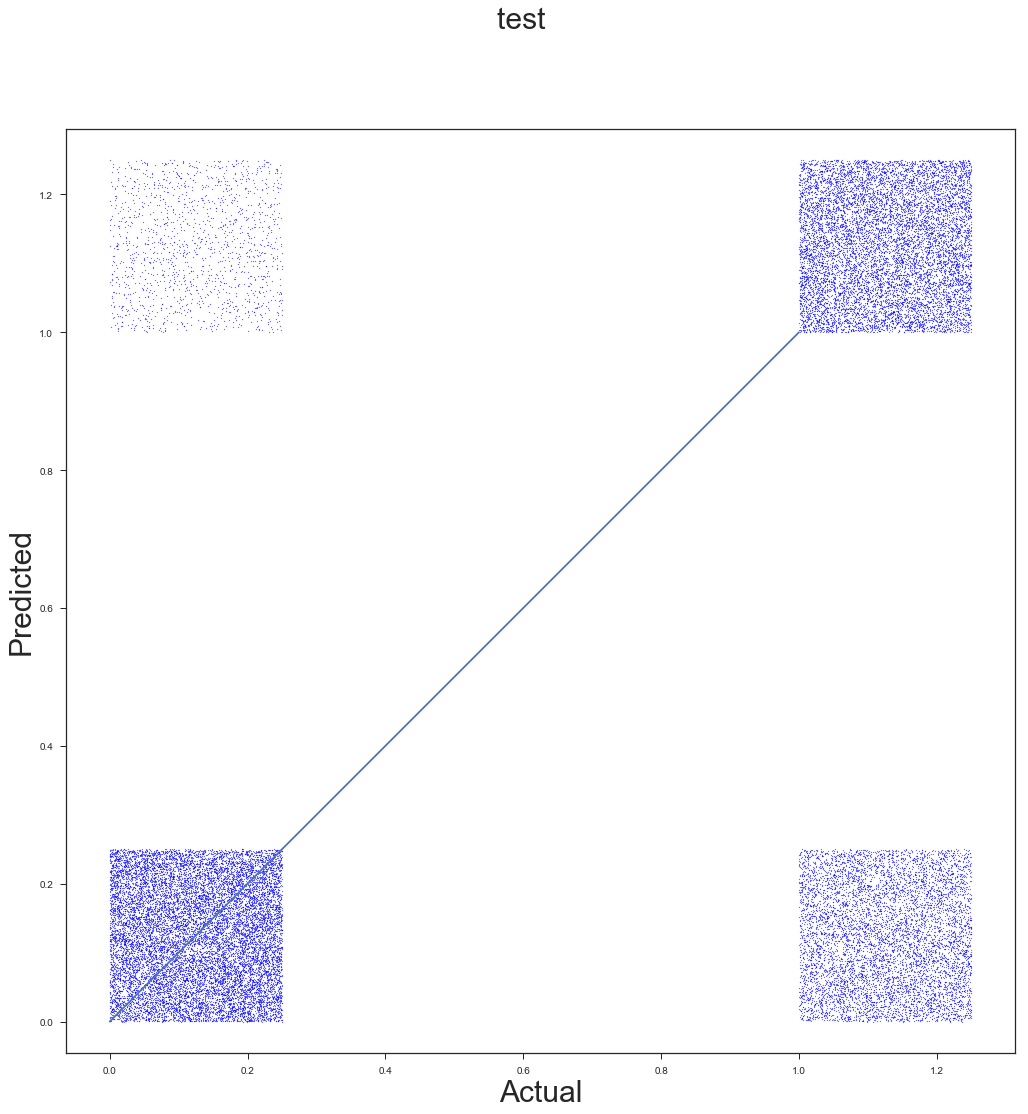

In [239]:
np.random.seed(19601)

#colors = df2['Wiki']
fig = plt.figure(figsize=(17,17))
#plt.scatter(df2[df2['State']=='Florida']['Votes'], df2[df2['State']=='Florida']['Prediction'], s=200,alpha=0.5, c='#4c2373')
plt.scatter(Y_plot, Y_predict, s=1,alpha=0.5, c='Blue', cmap = 'winter')
fig.suptitle('Scatter Plot - Predicted Vs Actual ',fontsize=30)
plt.ylabel('Predicted',fontsize=30)
plt.xlabel('Actual',fontsize=30)
plt.axis('equal')
#plt.yticks(np.arange(0.0, 1.1, 0.1))
#plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.legend(fontsize=30)
plt.plot( [0,1],[0,1] )
plt.show()